In [ ]:
from google.colab import drive # this is where I save the files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pulser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [ ]:
!pip install reservoirpy # package for classical reservoir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvic

In [ ]:
import numpy as np
from numpy import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import reservoirpy as rpy
rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everyhting reproducible !
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

import pulser
from pprint import pprint
from pulser import Pulse, Sequence, Register, Register3D
from pulser.devices import Chadoq2, MockDevice
from pulser.waveforms import BlackmanWaveform, ConstantWaveform, RampWaveform
from pulser_simulation import QutipEmulator, SimConfig
from pulser.register.special_layouts import SquareLatticeLayout
import qutip

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
import time

from itertools import chain
import collections, functools, operator
import random
random.seed(0)
import pickle
import os

from datetime import datetime
import csv
from csv import DictWriter

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
plt.rcParams.update({'font.size': 22})
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

In [ ]:
MAINPATH = os.getcwd()+'/drive/MyDrive/Colab/hyperparameter_search_qrc' # change to fit your path

In [ ]:
# load the Mackey Glass series

mackey = mackey_glass(2000)

scaler = MinMaxScaler(feature_range=(0.2, 1))
scaler.fit(mackey)
X = scaler.transform(mackey)

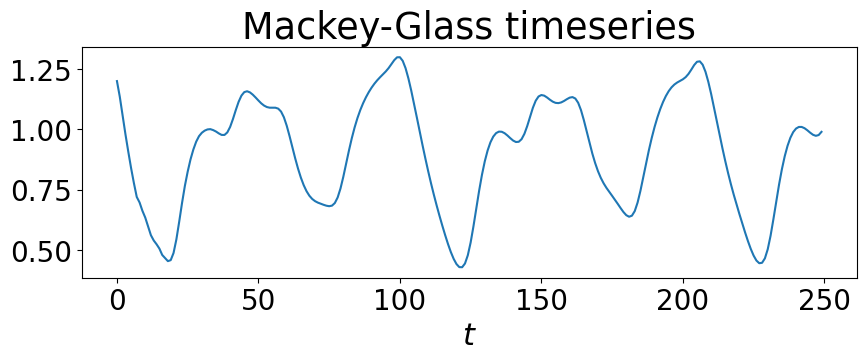

In [ ]:
plt.figure(figsize=(10, 3))
plt.xlabel("$t$")
plt.title("Mackey-Glass timeseries")
plt.plot(mackey[:250])
plt.show()

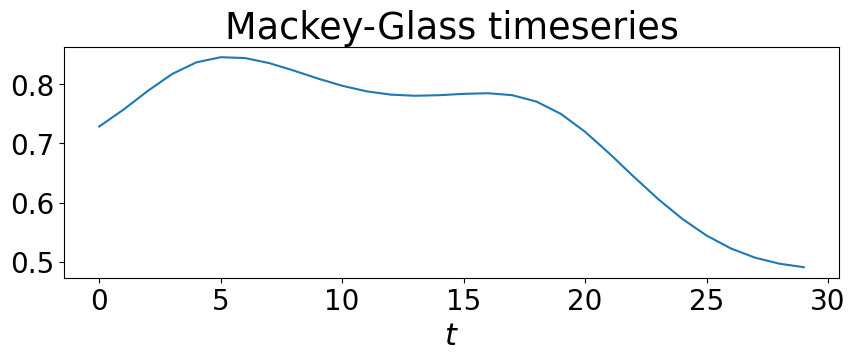

In [ ]:
plt.figure(figsize=(10, 3))
plt.xlabel("$t$")
plt.title("Mackey-Glass timeseries")
plt.plot(X[250:280])
plt.show()

In [ ]:
# create a simple sine time series, rescaled between 0.2 and 1 for encoding
sine = np.sin(np.linspace(0, 6*np.pi, 600)).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0.2, 1))
scaler.fit(sine)
sine = scaler.transform(sine)

In [ ]:
# full QRC model
class QRC:
  def __init__(self, nb_atoms, geometry, atom_distance, N_samples, sample_len, reset_rate, inp_duration, verbose=True):
    self.inp_duration = inp_duration
    self.N_samples = N_samples  # number of shots
    self.sample_len = sample_len # length of input time series
    self.reset_rate = reset_rate # probability of resetting the whole reservoir (for ESP)
    self.n = nb_atoms
    self.geom = geometry
    self.atom_distance = atom_distance
    self.verbose = verbose

  def grid_lattice(self, rows, columns, distance):
    """ Return a dictionnary corresponding to a grid lattice.
	Args:
		- rows: nbr of rows
		- columns: nbr of columns
		- distance: distance between two atoms (nm)
	Output:
		- a dictionnary that links the name of the atom with its position
	"""
    q_dict= {}
    for i in range(rows):
	    for j in range(columns):
		    q_dict["{}".format(i*rows+j)] = np.array([distance*i,distance*j])

    return(q_dict)

  def grid_lattice_centred(self, dim, distance):
    """ Return a dictionnary corresponding to a grid lattice.
	Args:
		- rows: nbr of rows
		- columns: nbr of columns
		- distance: distance between two atoms (nm)
	Output:
		- a dictionnary that links the name of the atom with its position
	"""
    offset = distance * (dim - 1) / 2

    q_dict= {}
    for i in range(dim):
	    for j in range(dim):
		    q_dict["{}".format(i * dim + j)] = np.array([distance * i, distance * j]) - offset

    return(q_dict)

  def layout(self):

    if self.geom=='grid_lattice':
        q_dict = self.grid_lattice(int(np.sqrt(self.n)), int(np.sqrt(self.n)), self.atom_distance)

    elif self.geom=='grid_lattice_centred':
        q_dict = self.grid_lattice_centred(int(np.sqrt(self.n)), self.atom_distance)

    reg = Register(q_dict)
    return reg


  def build_reservoir(self, inp_trunc):
    '''Encodes input_trunc as input parameters in local pulses and constructs the reservoir from the encoding.
    Returns all measurement outcomes associated with the truncated input'''


    tic = time.time() # measure the time it takes to construct, execute and measure all reservoirs
    inp_train = inp_trunc

    all_outcomes_list = [] # collect observed reservoir states here

    k_time = 0
    for k in range(len(inp_train)-self.sample_len):

        tic = time.time()

        inp = inp_train[k:k+self.sample_len] # extract subsection of time series to pass into the reservoir
        N = len(inp)

        seq = Sequence(self.reg, Chadoq2)
        seq.declare_channel("global", "rydberg_global")

        for i in range(len(inp)):

            duration = self.inp_duration # duration for which the reservoir will see the input = pulse duration

            rd.seed(0)
            reset = rd.choice(np.arange(0, 2), p=[1-self.reset_rate, self.reset_rate], size=1) # in case we want to add random noise

            if reset==1:
                print("reset")
                seq = Sequence(self.reg, Chadoq2)
                seq.declare_channel("global", "rydberg_global")

            else:
                amplitude = inp[i] # input is encoded in the pulse amplitude
                detuning = 0

                pulse = Pulse.ConstantPulse(duration, amplitude, detuning, phase=0.00, post_phase_shift=0.0)
                seq.add(pulse, "global")


        sim = QutipEmulator.from_sequence(seq, sampling_rate=1)

        results = sim.run(progress_bar=False)  # run the simulation
        outcomes = results.sample_final_state(N_samples=self.N_samples)
        all_outcomes_list.append(outcomes)

        toc = time.time()
        k_time += (toc-tic)

        if (k%10==0):
            if self.verbose:
                print(str(k)+" training steps finished, training time : ", k_time)
                k_time = 0

    return all_outcomes_list

  def train(self, data, train_len):
    '''Executes the training for all inputs. train_len is the number of train steps. Constructs the optimised weights from the training.'''
    self.data = data[:self.sample_len + train_len]

    self.reg = self.layout()

    total_time = 0
    tic = time.time()
    counts_list = self.build_reservoir(self.data)

    normalised_counts_list = [] # normalise the counts list so that it is coherent between train and test
    for count in counts_list:
        new_count = {k: v / self.N_samples for k, v in count.items() }
        normalised_counts_list.append(new_count)

    self.df = pd.DataFrame.from_dict(normalised_counts_list).fillna(0)
    self.X_all_train = self.df.to_numpy()

    Xp = np.linalg.pinv(self.X_all_train) # calculate pseudo inverse
    self.w = np.dot(Xp, self.data[self.sample_len:self.sample_len+len(counts_list)]) # calculate the weight vector (linear regression)

    toc = time.time()
    total_time += (toc-tic)
    print("Training finished. Total training time:", total_time)

    # evaluate training error
    self.y_pred_train=[]
    for l in range(len(counts_list)):
      self.y_pred_train.append(np.dot(self.X_all_train[l, :], self.w))
    self.val_data = self.data[self.sample_len:self.sample_len + train_len]
    mae_train = mean_absolute_error(self.val_data, self.y_pred_train)
    print("Train error: ", mae_train)

  def evaluate(self, test_data, test_len):
      '''Builds the reservoirs associated with the test data. Returns the observed hidden states and the predictions'''

      self.test_data = test_data[:self.sample_len+test_len]
      test_counts_list = self.build_reservoir(self.test_data)

      normalised_counts_list = []
      for count in test_counts_list:
        new_count = {k: v / self.N_samples for k, v in count.items() }
        normalised_counts_list.append(new_count)

      df_copy = self.df.iloc[:0,:].copy().fillna(0)
      df_copy = df_copy.append(normalised_counts_list, ignore_index=True, sort=False).fillna(0)
      self.X_all_test = df_copy.to_numpy()

      y_pred=[]
      for l in range(len(test_counts_list)):
        y_pred.append(np.dot(self.X_all_test[l, :], self.w))

      self.test_data_y = self.test_data[self.sample_len:self.sample_len+test_len]
      mae_test = mean_absolute_error(self.test_data_y, y_pred)
      print("Test error: ", mae_test)

      return self.X_all_test, y_pred

In [ ]:
# execute either this cell if you want to test a specific model with fixed hyperparameters,
# or cell ... if you want to do an exhaustive hyperparameter search

input_data = "mackey" # choose input data, mackey glass or sine curve

if input_data == "mackey":
    # split into train and test
    inp_train = mackey[:250]
    inp_test = mackey[250:280]

elif input_data == "sine":
    inp_train = sine[:250]
    inp_test = sine[250:280]


train_len = len(inp_train)
test_len = len(inp_test)
N_samples = 1024
reset_rate = 0
geometry = "grid_lattice_centred"

nb_atoms = 9 # to quickly test that the code works, try 4 atoms. To confirm our results, the hyperparameters are listed in the appendix of our pdf document

inp_duration = 1000
sample_len = 8
atom_distance = 15


real_train_len = train_len-sample_len
real_test_len = test_len-sample_len

qrc = QRC(nb_atoms=nb_atoms,
            geometry=geometry,
            atom_distance=atom_distance,
            N_samples=N_samples,
            sample_len=sample_len,
            reset_rate=reset_rate,
            inp_duration=inp_duration,
            verbose=True)

qrc.train(data=inp_train, train_len=real_train_len)

train_mae =  mean_absolute_error(qrc.val_data, qrc.y_pred_train)

test_counts, y_pred_test = qrc.evaluate(inp_test, test_len=real_test_len)

test_mae = mean_absolute_error(inp_test[sample_len:sample_len+test_len], y_pred_test)


header = ['input_data', 'train_len', 'test_len', 'inp_duration', 'N_samples', 'sample_len', 'reset_rate', 'nb_atoms', 'geometry', 'atom_distance', 'train_mae', 'test_mae']

dic = {'input_data': input_data,
        'train_len': train_len,
        'test_len': test_len,
        'inp_duration': inp_duration,
        'N_samples': N_samples,
        'sample_len': sample_len,
        'reset_rate': reset_rate,
        'nb_atoms': nb_atoms,
        'geometry': geometry,
        'atom_distance': atom_distance,
        'train_mae': train_mae,
        'test_mae': test_mae
        }

with open(MAINPATH+'/9_sine_grid.csv', 'a') as f_object:
            dictwriter_object = DictWriter(f_object, fieldnames=header)
            dictwriter_object.writerow(dic)
            f_object.close()

0 training steps finished, training time :  3.871687650680542
10 training steps finished, training time :  39.59634613990784
20 training steps finished, training time :  37.20709419250488
30 training steps finished, training time :  40.10847353935242
40 training steps finished, training time :  37.682400941848755
50 training steps finished, training time :  40.665701150894165
60 training steps finished, training time :  38.58556818962097
70 training steps finished, training time :  37.42777180671692
80 training steps finished, training time :  40.06083822250366
90 training steps finished, training time :  38.36064100265503
100 training steps finished, training time :  41.97602915763855
110 training steps finished, training time :  37.98288917541504
120 training steps finished, training time :  39.78809094429016
130 training steps finished, training time :  37.61075186729431
140 training steps finished, training time :  38.03281617164612
150 training steps finished, training time :  40.

In [ ]:
def calculate_metrics(preds, vals):
    return {'mae' : mean_absolute_error(vals, preds),
            'rmse' : mean_squared_error(vals, preds) ** 0.5,
            'r2' : r2_score(vals, preds)}

In [ ]:
# Calculate train and test score of the quantum reservoir

result_metrics_test = calculate_metrics(y_pred_test, inp_test[sample_len:sample_len+test_len])
result_metrics_train = calculate_metrics(qrc.y_pred_train, inp_train[sample_len:sample_len+train_len])

print("QRC Test: ", result_metrics_test)
print("QRC Train: ", result_metrics_train)

QRC Test:  {'mae': 0.0066269557921762486, 'rmse': 0.007967094755787133, 'r2': 0.9815142595253228}
QRC Train:  {'mae': 3.5090158510750686e-15, 'rmse': 4.191731792283007e-15, 'r2': 1.0}


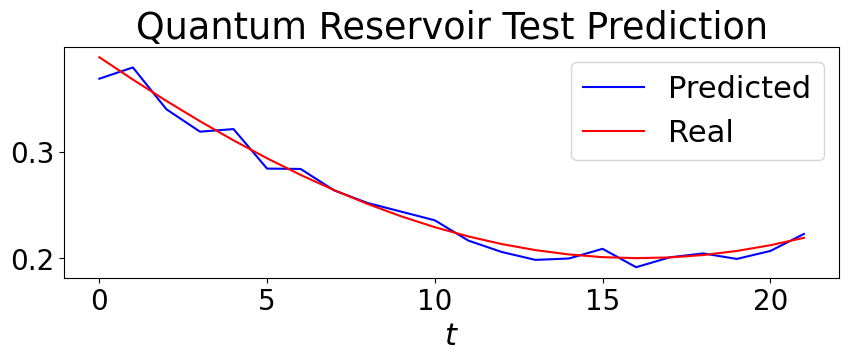

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Quantum Reservoir Test Prediction")
plt.xlabel("$t$")
plt.plot(y_pred_test, label="Predicted", color="blue")
plt.plot(inp_test[sample_len:sample_len+test_len], label="Real", color="red")
plt.legend()

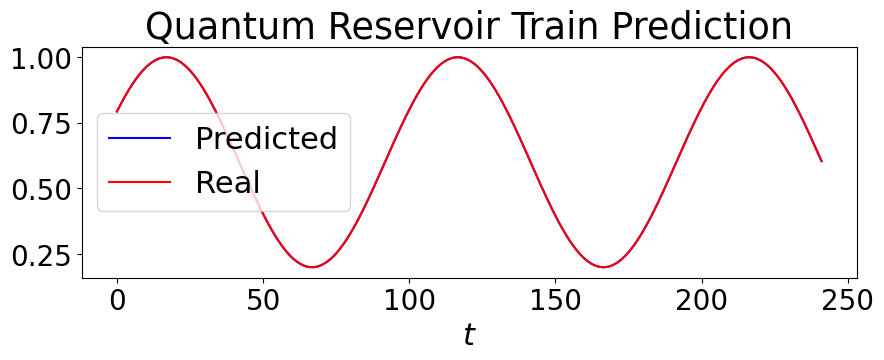

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Quantum Reservoir Train Prediction")
plt.xlabel("$t$")
plt.plot(qrc.y_pred_train, label="Predicted", color="blue")
plt.plot(inp_train[sample_len:sample_len+train_len], label="Real", color="red")
plt.legend()

# Compare to Linear Regression

Linear Regression performs better on sine data than a QRC with 4 atoms, but the QRC with 9 atoms outperforms the linear regression. See the notebook "plots" for details.

In [ ]:
# compare to linear regression

def build_baseline_model(X_train, y_train, X_test, y_test):

    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    return prediction

In [ ]:
X_train = inp_train[:-1]
y_train = inp_train[1:]

X_test = inp_test[:-1]
y_test = inp_test[1:]

In [ ]:
lin_reg = build_baseline_model(X_train[sample_len:sample_len+train_len], y_train[sample_len:sample_len+train_len], X_test[sample_len:sample_len+test_len], y_test[sample_len:sample_len+test_len])
lin_reg_train = build_baseline_model(X_train[sample_len:sample_len+train_len], y_train[sample_len:sample_len+train_len], X_train[sample_len:sample_len+train_len], y_train[sample_len:sample_len+train_len])

In [ ]:
lin_reg_metrics = calculate_metrics(lin_reg, y_test[sample_len:sample_len+test_len])
lin_reg_train_metrics = calculate_metrics(lin_reg_train, y_train[sample_len:sample_len+train_len])


print("LinReg Test: ", lin_reg_metrics)
print("LinReg Train: ", lin_reg_train_metrics)

LinReg Test:  {'mae': 0.009916498844391799, 'rmse': 0.011865513238491167, 'r2': 0.9476902968786641}
LinReg Train:  {'mae': 0.01574841407735916, 'rmse': 0.017541077371014766, 'r2': 0.9961445750401688}


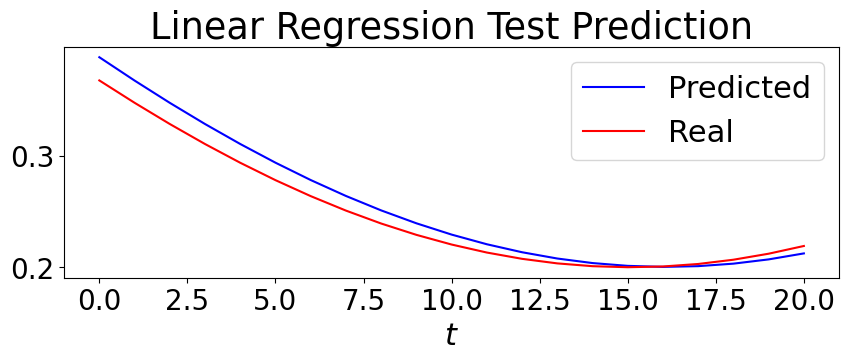

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Linear Regression Test Prediction")
plt.xlabel("$t$")
plt.plot(lin_reg, label="Predicted", color="blue")
plt.plot(y_test[sample_len:sample_len+test_len], label="Real", color="red")
plt.legend()

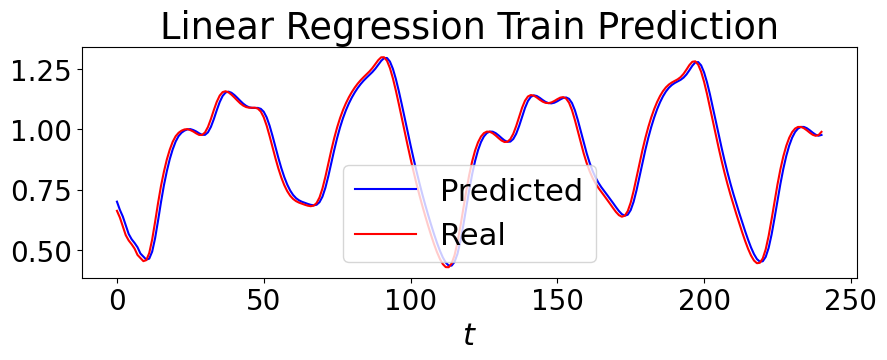

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Linear Regression Train Prediction")
plt.xlabel("$t$")
plt.plot(lin_reg_train, label="Predicted", color="blue")
plt.plot(y_train[sample_len:sample_len+train_len], label="Real", color="red")
plt.legend()

# Compare to Classical RC

In [ ]:
# create data for the classical RC

input_data = "sine" # choose input data, mackey glass or sine curve

train_data_len = 250
test_data_len = 30

if input_data == "mackey":
    inp_train = mackey[:train_data_len]
    inp_test = mackey[train_data_len:train_data_len+test_data_len]

elif input_data == "sine":
    inp_train = sine[:train_data_len]
    inp_test = sine[train_data_len:train_data_len+test_data_len]

X_train_rc = inp_train[:-1]
y_train_rc = inp_train[1:]

X_test_rc = inp_test[:-1]

y_test_rc = inp_test[1:]

Classical RC Test:  {'mae': 0.2862774251190474, 'rmse': 0.2903474480926316, 'r2': -34.92078291822762}
Classical RC Train:  {'mae': 0.2490196814488034, 'rmse': 0.2795740736357835, 'r2': 2.220446049250313e-16}


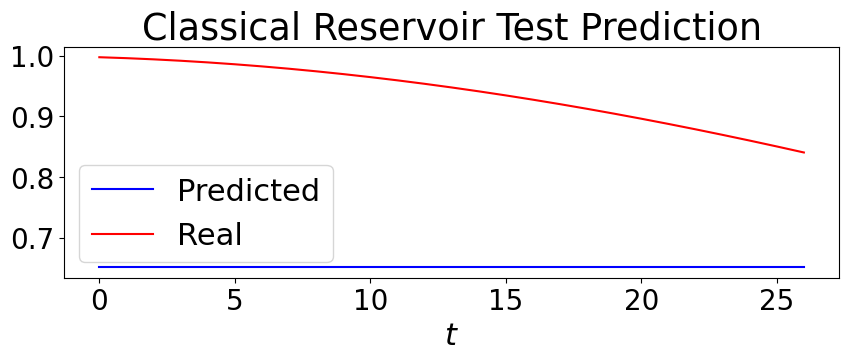

In [ ]:
sample_len = 2
train_len = int(len(inp_train)-sample_len)
test_len = int(len(inp_test)-sample_len)

neuron_number = 4

rpy.set_seed(0)

reservoir = Reservoir(neuron_number, lr=1, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

esn_model = esn_model.fit(X_train_rc[sample_len:sample_len+train_len], y_train_rc[sample_len:sample_len+train_len], warmup=0)

Y_pred_train = esn_model.run(X_train_rc[sample_len:sample_len+train_len])
Y_pred_test = esn_model.run(X_test_rc[sample_len:sample_len+test_len])

plt.figure(figsize=(10, 3))
plt.title("Classical Reservoir Test Prediction")
plt.xlabel("$t$")
plt.plot(Y_pred_test, label="Predicted", color="blue")
plt.plot(y_test_rc[sample_len:sample_len+test_len], label="Real", color="red")
plt.legend()

metrics_train = calculate_metrics(Y_pred_train, y_train_rc[sample_len:sample_len+train_len])
metrics_test = calculate_metrics(Y_pred_test, y_test_rc[sample_len:sample_len+test_len])

print("Classical RC Test: ", metrics_test)
print("Classical RC Train: ", metrics_train)

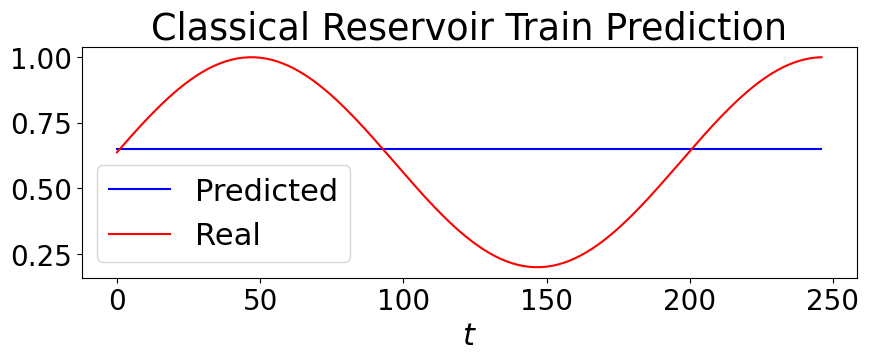

In [ ]:
plt.figure(figsize=(10, 3))
plt.title("Classical Reservoir Train Prediction")
plt.xlabel("$t$")
plt.plot(Y_pred_train, label="Predicted", color="blue")
plt.plot(y_train_rc[sample_len:sample_len+train_len], label="Real", color="red")
plt.legend()

# Extensive Hyperparameter Search for the QRC

In [ ]:
header = ['input_data', 'train_len', 'test_len', 'inp_duration', 'N_samples', 'sample_len', 'reset_rate', 'nb_atoms', 'geometry', 'atom_distance', 'train_mae', 'test_mae']

with open(MAINPATH+'/9_sine_grid.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)

In [ ]:
# Hyperparameter Search

input_data = 'sine'

if input_data == "mackey":
    # split into train and test
    inp_train = mackey[:250]
    inp_test = mackey[250:280]

elif input_data == "sine":
    inp_train = sine[:250]
    inp_test = sine[250:280]

train_len = len(inp_train)
test_len = len(inp_test)
N_samples = 1024
reset_rate = 0
geometry = "grid_lattice_centred"

nb_atoms = 9

inp_duration_list = [16, 100, 1000]
sample_len_list = [2, 3, 6, 8, 9, 10]
atom_distance_list = [4, 8, 11, 13, 15, 14, 20, 35]

k = 0
run_time = len(inp_duration_list)*len(sample_len_list)*len(atom_distance_list)

for inp_duration in inp_duration_list:
    for sample_len in sample_len_list:
        for atom_distance in atom_distance_list:

            k+=1

            real_train_len = train_len-sample_len
            real_test_len = test_len-sample_len

            qrc = QRC(nb_atoms=nb_atoms,
                      geometry=geometry,
                      atom_distance=atom_distance,
                      N_samples=N_samples,
                      sample_len=sample_len,
                      reset_rate=reset_rate,
                      inp_duration=inp_duration,
                      verbose=True)

            qrc.train(data=inp_train, train_len=real_train_len)

            train_mae =  mean_absolute_error(qrc.val_data, qrc.y_pred_train)

            test_counts, y_pred_test = qrc.evaluate(inp_test, test_len=real_test_len)

            test_mae = mean_absolute_error(inp_test[sample_len:sample_len+test_len], y_pred_test)

            print(str(k)," out of ", str(run_time))

            dic = {'input_data': input_data,
                   'train_len': train_len,
                   'test_len': test_len,
                   'inp_duration': inp_duration,
                   'N_samples': N_samples,
                   'sample_len': sample_len,
                   'reset_rate': reset_rate,
                   'nb_atoms': nb_atoms,
                   'geometry': geometry,
                   'atom_distance': atom_distance,
                   'train_mae': train_mae,
                   'test_mae': test_mae
                   }

            with open(MAINPATH+'/9_sine_grid.csv', 'a') as f_object:
                        dictwriter_object = DictWriter(f_object, fieldnames=header)
                        dictwriter_object.writerow(dic)
                        f_object.close()

# Hyperparameter Search fo Classical RC

In [ ]:
header = ['input_data', 'train_len', 'test_len', 'neuron_number', 'sample_len', 'train_mae', 'test_mae']

with open(MAINPATH+'/classical_grid.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)

In [ ]:
# create data for the classical RC

input_data_list = ["sine", "mackey"]

train_len_list = [250, 300, 350, 400, 450, 500, 550]
neuron_number_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100]

test_data_len = 30

for input_data in input_data_list:

    for train_data_len in train_len_list:
        for neuron_number in neuron_number_list:


            if input_data == "mackey":
                sample_len = 8

                inp_train = mackey[:train_data_len]
                inp_test = mackey[train_data_len:train_data_len+test_data_len]

            elif input_data == "sine":
                sample_len = 2

                inp_train = sine[:train_data_len]
                inp_test = sine[train_data_len:train_data_len+test_data_len]

            X_train_rc = inp_train[:-1]
            y_train_rc = inp_train[1:]

            X_test_rc = inp_test[:-1]

            y_test_rc = inp_test[1:]


            train_len = int(len(inp_train)-sample_len)
            test_len = int(len(inp_test)-sample_len)

            rpy.set_seed(0)

            reservoir = Reservoir(neuron_number, lr=1, sr=0.9)
            ridge = Ridge(ridge=1e-7)

            esn_model = reservoir >> ridge

            esn_model = esn_model.fit(X_train_rc[sample_len:sample_len+train_len], y_train_rc[sample_len:sample_len+train_len], warmup=0)

            Y_pred_train = esn_model.run(X_train_rc[sample_len:sample_len+train_len])
            Y_pred_test = esn_model.run(X_test_rc[sample_len:sample_len+test_len])

            metrics_train = calculate_metrics(Y_pred_train, y_train_rc[sample_len:sample_len+train_len])['mae']
            metrics_test = calculate_metrics(Y_pred_test, y_test_rc[sample_len:sample_len+test_len])['mae']

            print("Classical RC Test: ", metrics_test)
            print("Classical RC Train: ", metrics_train)

            dic = {'input_data': input_data,
                    'train_len': train_data_len,
                    'test_len': test_data_len,
                    'neuron_number': neuron_number,
                    'sample_len': sample_len,
                    'train_mae': metrics_train,
                    'test_mae': metrics_test
                    }

            with open(MAINPATH+'/classical_grid.csv', 'a') as f_object:
                        dictwriter_object = DictWriter(f_object, fieldnames=header)
                        dictwriter_object.writerow(dic)
                        f_object.close()

Classical RC Test:  0.2862774251190474
Classical RC Train:  0.2490196814488034
Classical RC Test:  0.2862774251190474
Classical RC Train:  0.2490196814488034
Classical RC Test:  0.019234278675541245
Classical RC Train:  0.02582841192192403
Classical RC Test:  0.019963040657628536
Classical RC Train:  0.025322895510563853
Classical RC Test:  0.0194878356333745
Classical RC Train:  0.02623672667365222
Classical RC Test:  0.043072688017909005
Classical RC Train:  0.0485913273181426
Classical RC Test:  0.01924310194355045
Classical RC Train:  0.025828833901651485
Classical RC Test:  0.005478899888002645
Classical RC Train:  0.00582868465990452
Classical RC Test:  0.009294449441821949
Classical RC Train:  0.008928395121949689
Classical RC Test:  0.012968527370248582
Classical RC Train:  0.01658567446991798
Classical RC Test:  0.018994131264996383
Classical RC Train:  0.02582177024030972
Classical RC Test:  0.00423368435620821
Classical RC Train:  0.005706397430297967
Classical RC Test:  0.0